In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bus-sample-1/bus_sample.csv


In [3]:
import pandas as pd

# Читаем sample прямо из input
df = pd.read_csv('/kaggle/input/bus-sample-1/bus_sample.csv')
print(df.head())


   RecordedDayOfWeek  RecordedHour  RecordedMinute  RecordedSecond  \
0                  6            23              51              41   
1                  2             7              59               7   
2                  4            19              36              19   
3                  3            10               8              53   
4                  6            19              31              11   

   DirectionRef  DistanceToNextStop  PublishedLineName  NextStopPointName  \
0             0         4605.045211           0.895243           0.506667   
1             1         3310.630710           0.952276           1.035507   
2             0         3460.438678           0.609702           0.720000   
3             0          560.078145           0.919592           0.470833   
4             1          497.063954           0.664653           0.816667   

   TimeToArrival  
0       0.166667  
1       1.333333  
2       0.233333  
3       0.283333  
4       0.250000  


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


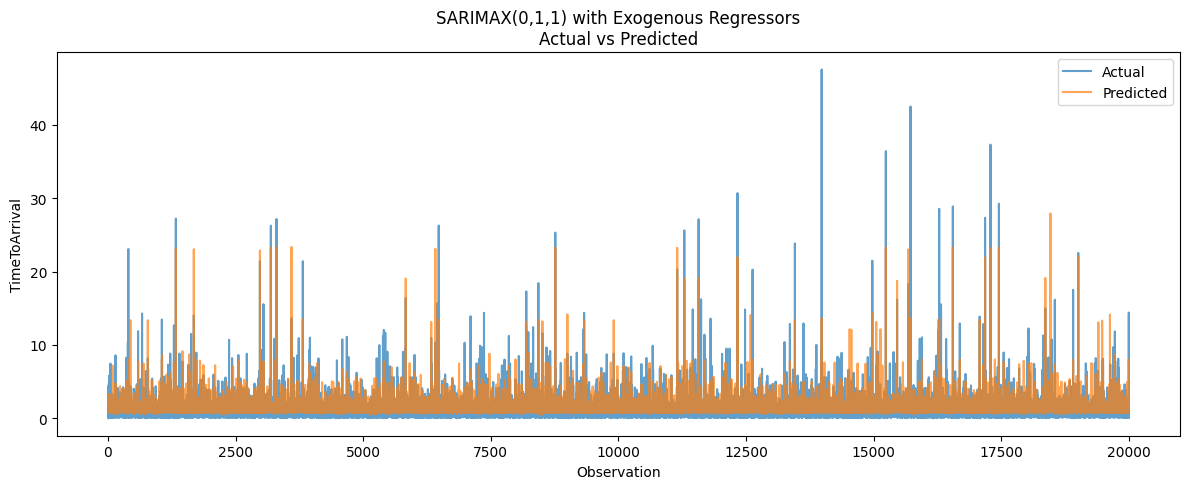

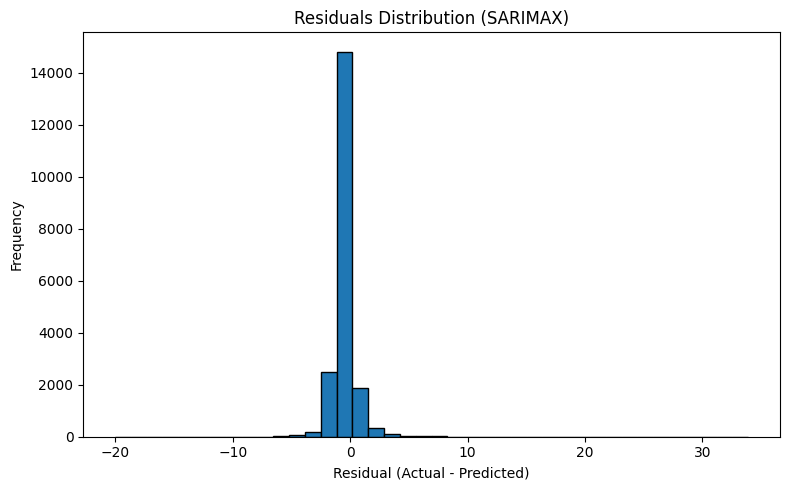

MAE: 0.809  RMSE: 1.184  R²: 0.447


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('/kaggle/input/bus-sample-1/bus_sample.csv')

y = df['TimeToArrival'].astype(float)
exog = df[['RecordedDayOfWeek', 'RecordedHour', 'RecordedMinute', 'RecordedSecond',
           'DirectionRef', 'DistanceToNextStop', 'PublishedLineName', 'NextStopPointName']].astype(float)

split = int(len(y) * 0.8)
y_train, y_test = y.iloc[:split], y.iloc[split:]
exog_train, exog_test = exog.iloc[:split], exog.iloc[split:]

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(0, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

y_pred = model.predict(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=exog_test
)

plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred.reset_index(drop=True), label='Predicted', alpha=0.7)
plt.xlabel('Observation')
plt.ylabel('TimeToArrival')
plt.title('SARIMAX(0,1,1) with Exogenous Regressors\nActual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

residuals = y_test.values - y_pred.values
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Residuals Distribution (SARIMAX)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.3f}  RMSE: {rmse:.3f}  R²: {r2:.3f}")


<Figure size 1000x500 with 0 Axes>

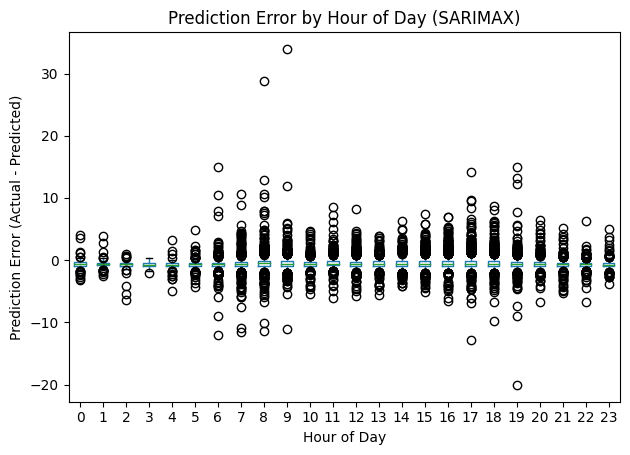

In [12]:
errors = y_test.values - y_pred.values  # make sure both are numpy arrays
df_box = exog_test.copy()
df_box['error'] = errors
df_box['RecordedHour'] = df_box['RecordedHour'].astype(int)

plt.figure(figsize=(10, 5))
df_box.boxplot(column='error', by='RecordedHour', grid=False)
plt.xlabel('Hour of Day')
plt.ylabel('Prediction Error (Actual - Predicted)')
plt.title('Prediction Error by Hour of Day (SARIMAX)')
plt.suptitle('')
plt.tight_layout()
plt.show()
